 **Story Point Estimation**

In [1]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_absolute_error,mean_squared_error

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D,CuDNNLSTM,GRU
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import re
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 
from gensim.models import word2vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

files=['Mesos','aptStudio','TalendESB',
       'Duracloud','JIRASoftware','Colver','TalendDataquality',
       'appcele','Usergrid','bamboo','titanium',
       'MuleStudio','SpringXD','Mule']

Using TensorFlow backend.


**Preprocessing test**

In [2]:
#Testing the pre processing function in titanium project
df=pd.read_csv("../input/shravan1/titanium.csv",encoding='latin-1')
def preprocess(sentence):
        sentence=str(sentence)
        sentence = sentence.lower()
        sentence=sentence.replace('{html}',"") 
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', sentence)
        rem_url=re.sub(r'http\S+', '',cleantext)
        rem_num = re.sub('[0-9]+', '', rem_url)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(rem_num)  
        filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
        return " ".join(filtered_words)

df['mergeText']=df['title'] .map(str)+str(" ")+df['description']
df['cleanText']=df['mergeText'].map(lambda s:preprocess(s)) 

In [3]:
df['title'] [4]

'iOS: Drag and drop map pin annotations'

In [4]:
df['description'][4]

'{html}<div><p>MKAnnotationView has support for allowing a map annotation to be  draggable (in iOS 4).<br>  Boolean property on Annotation object - draggable:true/false<br>  Add associated Events - e.g. DragStart &amp; DragEnd etc.</p></div>{html}'

In [5]:
df['cleanText'][4]

'ios drag drop map pin annotations mkannotationview support allowing map annotation draggable ios boolean property annotation object draggable true false add associated events dragstart amp dragend etc'

**Glove example**

In [8]:
import numpy as np
def loadGloveModel(gloveFile,i):
    print ("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([val for val in splitLine[1:]])
        model[word] = embedding
        if len(model)==100000:
            break
    print ("Done. words loaded!")
    print('word : ',i)
    print('len of the vector',len(model[i]))
    return model[i]
loadGloveModel('../input/embeddings/glove.840B.300d/glove.840B.300d.txt','android')


Loading Glove Model
Done. words loaded!
word :  android
len of the vector 300


array(['-0.23743', '-0.29257', '0.15377', '0.77249', '0.010905',
       '0.079027', '0.69377', '-0.22317', '0.64498', '-0.14812',
       '-0.43561', '-0.50568', '-0.27966', '0.14338', '-0.12513',
       '-0.18359', '-0.55844', '1.2105', '0.090157', '-0.12987',
       '-0.29118', '0.29761', '0.09248', '-0.22891', '-0.42215',
       '0.19436', '0.079696', '-0.18053', '0.59556', '0.57981', '0.41337',
       '-0.63258', '-0.0094914', '0.41927', '0.044773', '-0.19063',
       '-0.44666', '0.22189', '-0.35559', '-0.32318', '0.070914',
       '-0.75177', '0.096137', '0.14165', '-0.38868', '0.53115',
       '-0.40099', '0.008845', '-0.6739', '-0.31581', '-0.17985',
       '-0.75444', '-0.63824', '-0.94106', '-0.10357', '0.13271',
       '-0.31798', '-0.075458', '-0.24898', '-0.088029', '-0.17372',
       '-0.15017', '0.56489', '-0.19696', '0.35566', '-0.69536',
       '0.088325', '-0.18248', '-0.1494', '-0.38777', '-0.24951',
       '0.39125', '0.13484', '-0.062459', '0.63767', '-0.11435',
   

In [9]:
loadGloveModel('../input/embeddings/glove.840B.300d/glove.840B.300d.txt','hello')

Loading Glove Model
Done. words loaded!
word :  hello
len of the vector 300


array(['0.25233', '0.10176', '-0.67485', '0.21117', '0.43492', '0.16542',
       '0.48261', '-0.81222', '0.041321', '0.78502', '-0.077857',
       '-0.66324', '0.1464', '-0.29289', '-0.25488', '0.019293',
       '-0.20265', '0.98232', '0.028312', '-0.081276', '-0.1214',
       '0.13126', '-0.17648', '0.13556', '-0.16361', '-0.22574',
       '0.055006', '-0.20308', '0.20718', '0.095785', '0.22481',
       '0.21537', '-0.32982', '-0.12241', '-0.40031', '-0.079381',
       '-0.19958', '-0.015083', '-0.079139', '-0.18132', '0.20681',
       '-0.36196', '-0.30744', '-0.24422', '-0.23113', '0.09798',
       '0.1463', '-0.062738', '0.42934', '-0.078038', '-0.19627',
       '0.65093', '-0.22807', '-0.30308', '-0.12483', '-0.17568',
       '-0.14651', '0.15361', '-0.29518', '0.15099', '-0.51726',
       '-0.033564', '-0.23109', '-0.7833', '0.018029', '-0.15719',
       '0.02293', '0.49639', '0.029225', '0.05669', '0.14616', '-0.19195',
       '0.16244', '0.23898', '0.36431', '0.45263', '0.2456'

**Data Exploration**

1 /14
../input/shravan1/Mesos.csv


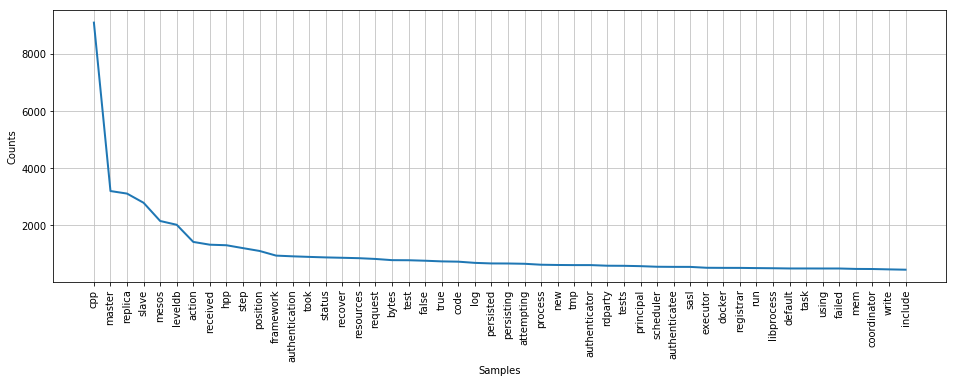

2 /14
../input/shravan1/aptStudio.csv


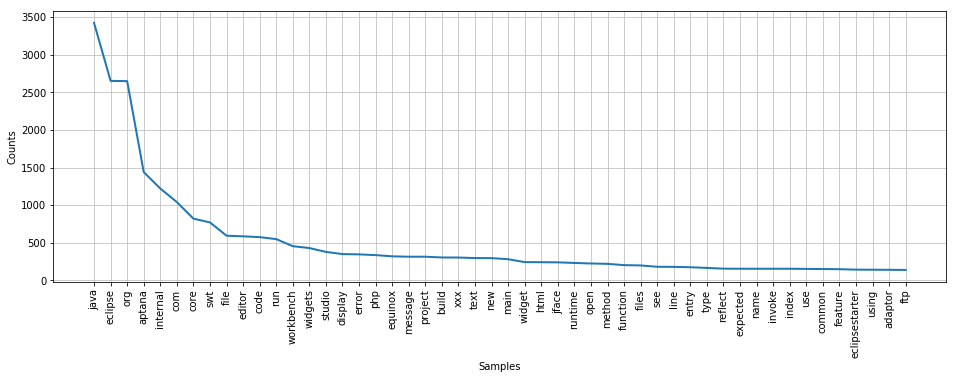

3 /14
../input/shravan1/TalendESB.csv


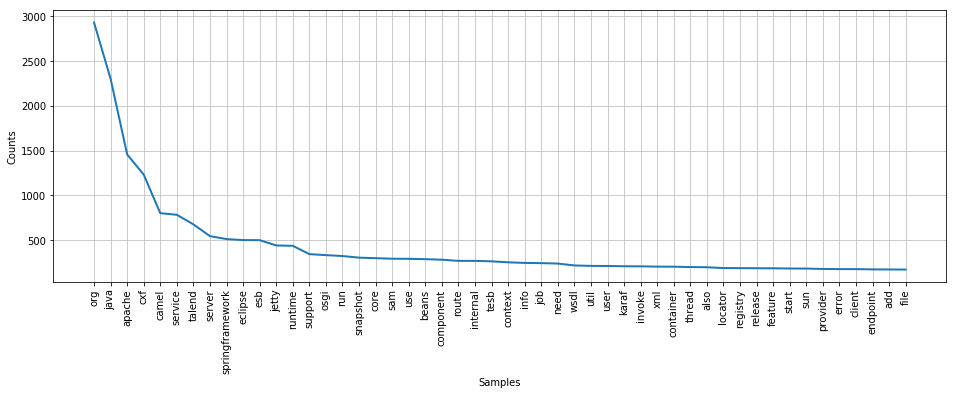

4 /14
../input/shravan1/Duracloud.csv


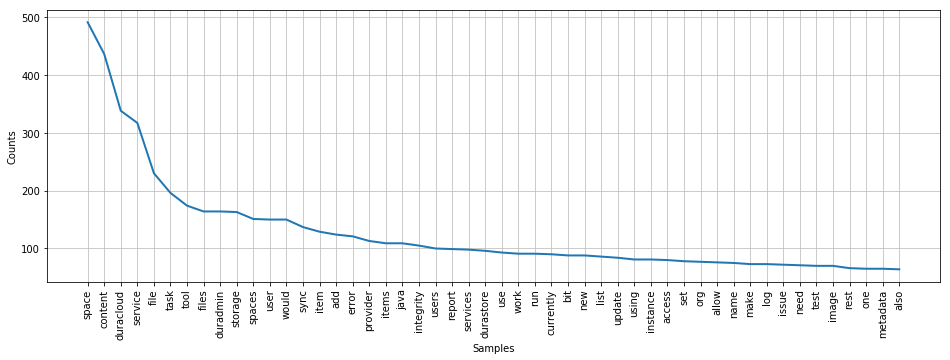

5 /14
../input/shravan1/JIRASoftware.csv


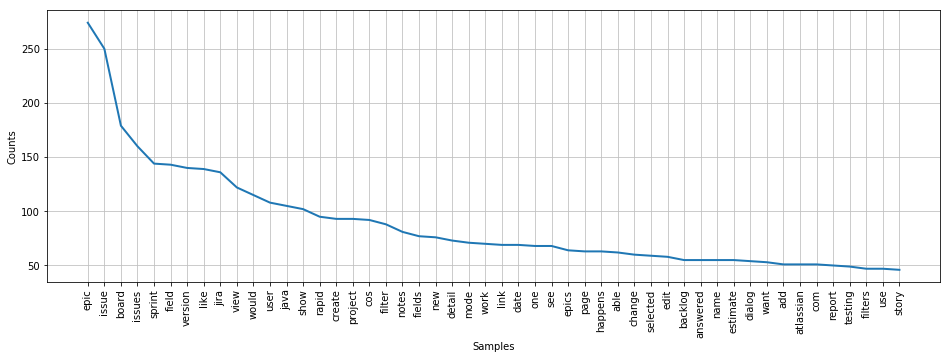

6 /14
../input/shravan1/Colver.csv


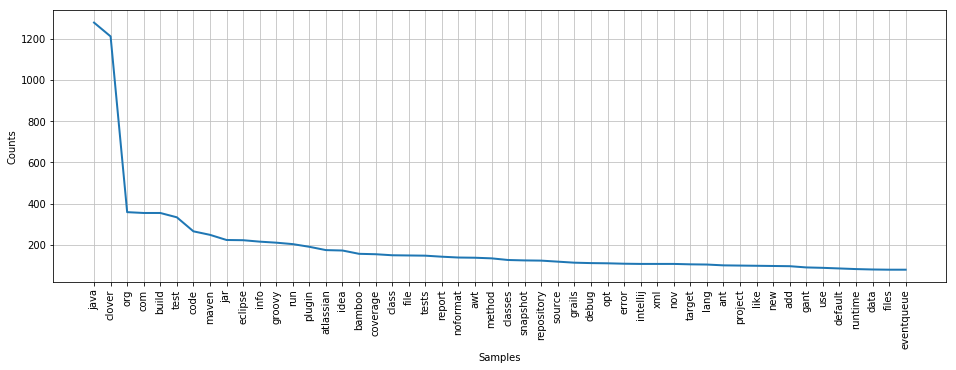

7 /14
../input/shravan1/TalendDataquality.csv


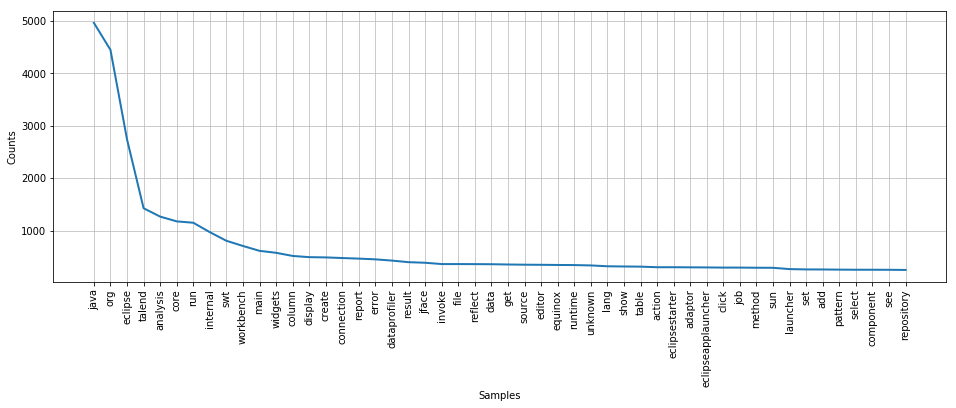

8 /14
../input/shravan1/appcele.csv


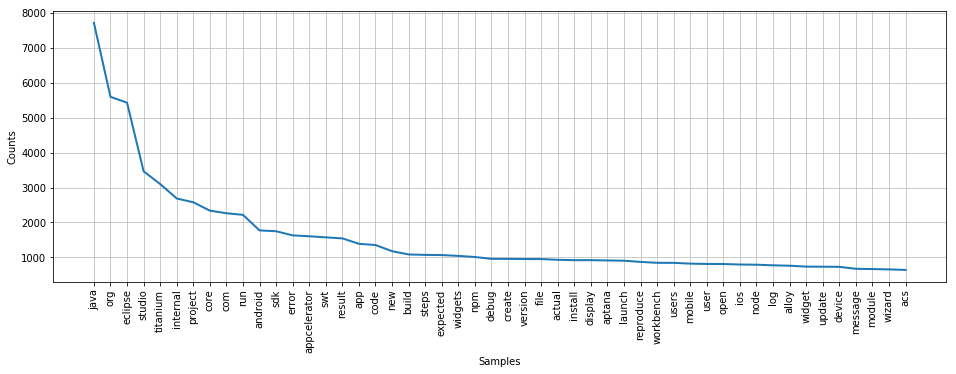

9 /14
../input/shravan1/Usergrid.csv


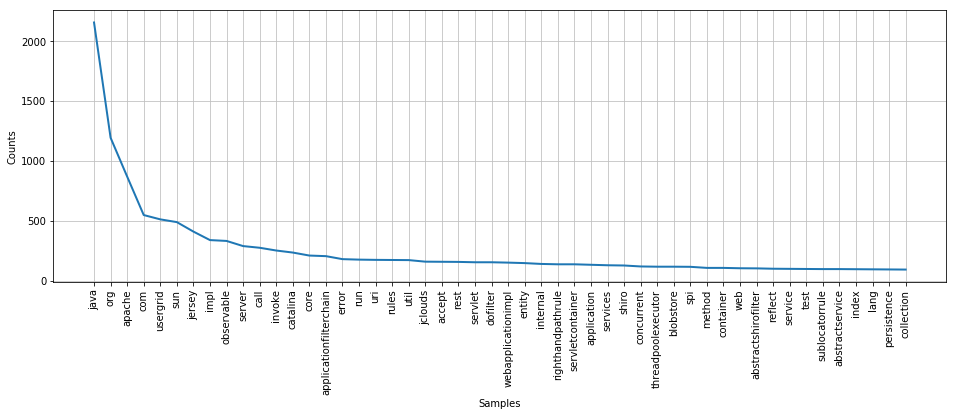

10 /14
../input/shravan1/bamboo.csv


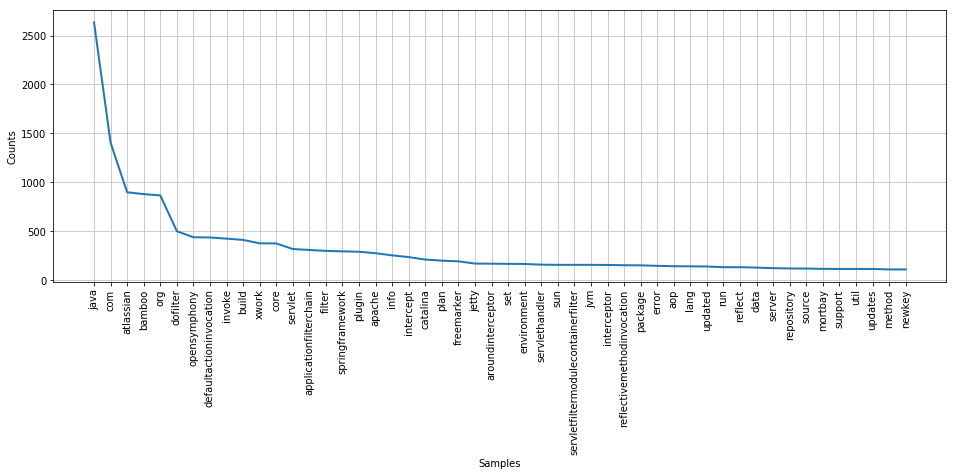

11 /14
../input/shravan1/titanium.csv


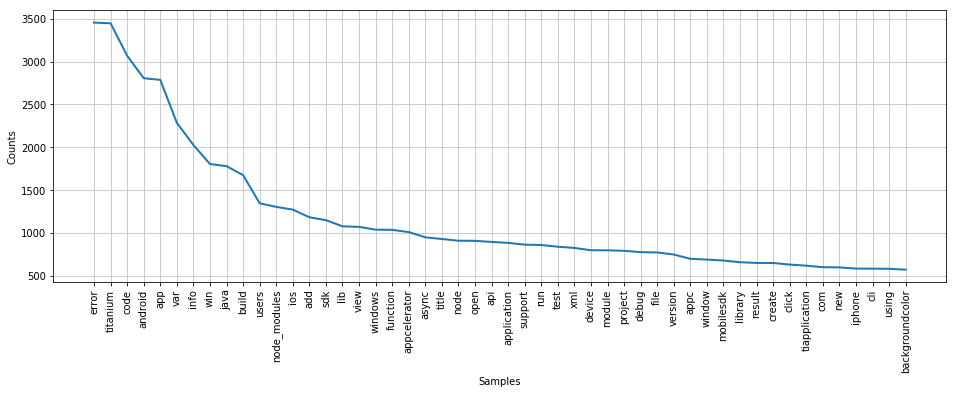

12 /14
../input/shravan1/MuleStudio.csv


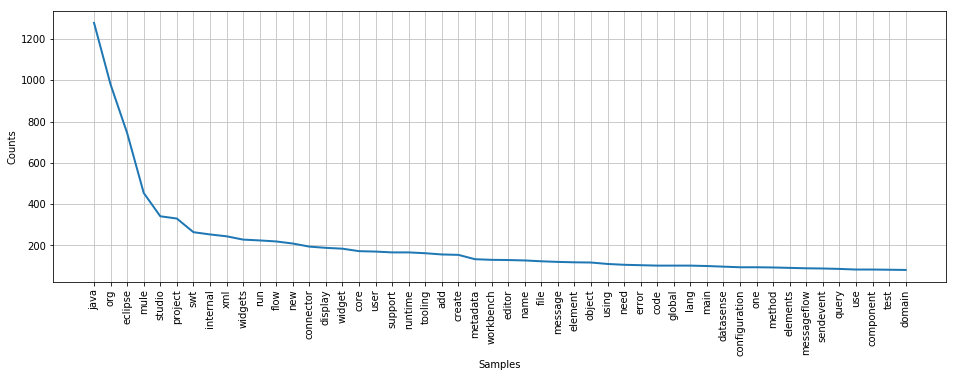

13 /14
../input/shravan1/SpringXD.csv


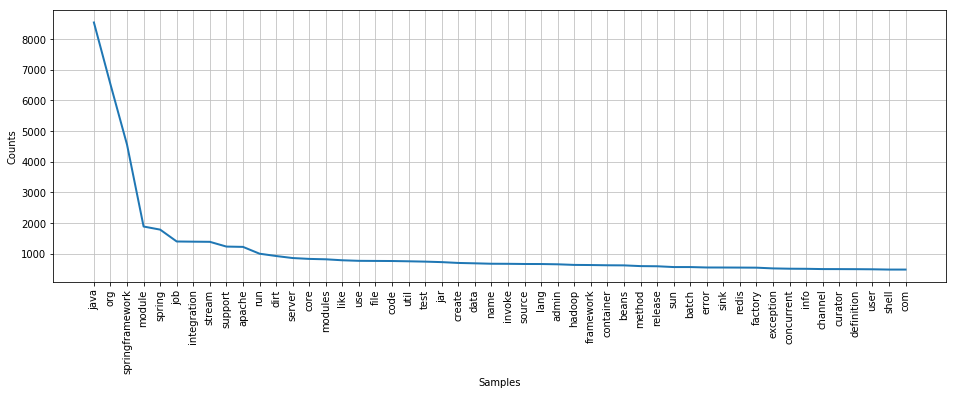

14 /14
../input/shravan1/Mule.csv


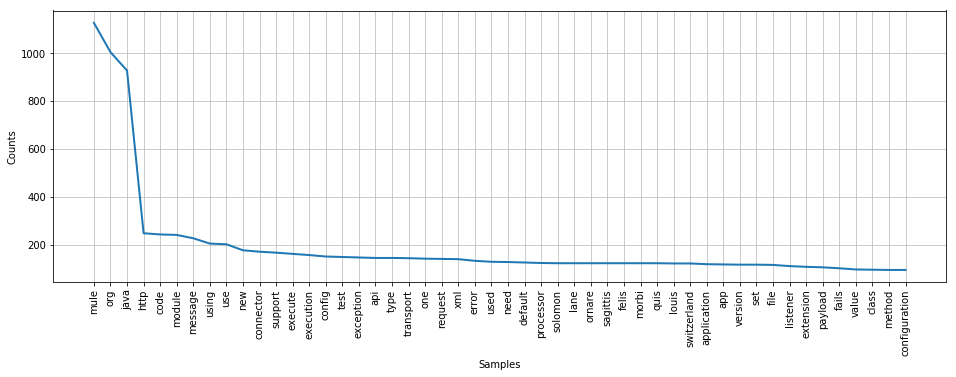

CPU times: user 3min 7s, sys: 16.8 s, total: 3min 24s
Wall time: 3min 21s


In [10]:
%%time
count=1
import glob
#Enter the path where files are saved 
path = "../input/shravan1/*.csv"
for fname in glob.glob(path):
    df=pd.read_csv(fname,encoding='latin-1')
    print(count,'/14')
    count=count+1
 #--------preprocessing--------#   
    def preprocess(sentence):
        sentence=str(sentence)
        sentence = sentence.lower()
        sentence=sentence.replace('{html}',"") 
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', sentence)
        rem_url=re.sub(r'http\S+', '',cleantext)
        rem_num = re.sub('[0-9]+', '', rem_url)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(rem_num)  
        filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
        return " ".join(filtered_words)

    df['mergeText']=df['title'] .map(str)+str(" ")+df['description']
    df['cleanText']=df['mergeText'].map(lambda s:preprocess(s)) 
    print(fname)
    string=""
    for i in df['cleanText']:
        string=("".join(i))+string
    import matplotlib.pyplot as plt
    freqdist = nltk.FreqDist(string.split())
    plt.figure(figsize=(16,5))
    freqdist.plot(50)

In [11]:
# creating the list of word for generating the tsne graph to check the wordvectors simialrity
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['cleanText']:
        for sentence in df[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
            
    return corpus

corpus = build_corpus(df) 

In [12]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [ ]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove2word2vec(glove_input_file='../input/embeddings/glove.840B.300d/glove.840B.300d.txt', word2vec_output_file="gensim_glove_vectors.txt")

In [ ]:
from gensim.models.keyedvectors import KeyedVectors
glove_model = KeyedVectors.load_word2vec_format("gensim_glove_vectors.txt", binary=False)

In [30]:
model = glove_model(corpus, size=200, window=20, min_count=80, workers=4)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


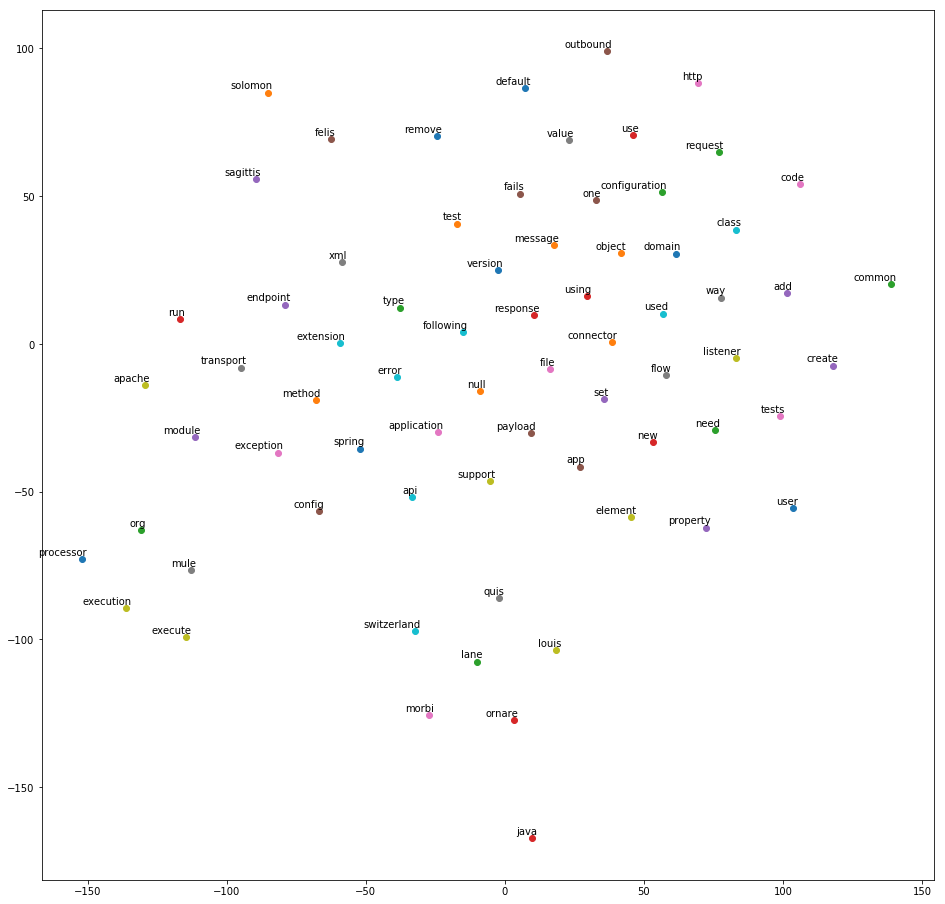

In [31]:
tsne_plot(model)

**Regression**

In [ ]:
#creating the array with different dense layers for calculating the MAE values 
mae_glove_dense_2=[]
mae_glove_dense_4=[]
mae_glove_dense_8=[]
mae_glove_dense_16=[]
mae_glove_dense_32=[]
mae_glove_dense_64=[]

In [ ]:
%%time
count=1
import glob
path = "../input/shravan1/*.csv"
for fname in glob.glob(path):
    df=pd.read_csv(fname,encoding='latin-1')
    print(count,'/14')
    count=count+1
 #--------preprocessing--------#   
    def preprocess(sentence):
        sentence=str(sentence)
        sentence = sentence.lower()
        sentence=sentence.replace('{html}',"") 
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', sentence)
        rem_url=re.sub(r'http\S+', '',cleantext)
        rem_num = re.sub('[0-9]+', '', rem_url)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(rem_num)  
        filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
        return " ".join(filtered_words)

    df['mergeText']=df['title'] .map(str)+str(" ")+df['description']
    df['cleanText']=df['mergeText'].map(lambda s:preprocess(s)) 
    
    print(fname ,': preprocessing done')
    
    #--------- train_test_split (70:30) ---------#
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=2018)
    
    ## some config values 
    embed_size = 300 # how big is each word vector
    max_features = 1000 # how many unique words to use (i.e num rows in embedding vector)
    maxlen = 100 # max number of words in a question to use

    ## fill up the missing values
    train_X = train_df["cleanText"].fillna("_na_").values
    val_X = val_df["cleanText"].fillna("_na_").values


    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    

    ## Get the target values
    train_y = train_df['storypoint'].values
    val_y = val_df['storypoint'].values
    
    #Load glove embedding file
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]


    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    print(fname ,': embedding done')
    
   
    dense=[2,4,8,16,32,64]
    
    #with glove embedding method
    for i in dense:
        inp = Input(shape=(maxlen,))
        x = Embedding(max_features, embed_size)(inp)
        x = Bidirectional(GRU(64, return_sequences=True))(x)
        x = GlobalMaxPool1D()(x)
        x = Dense(i, activation="relu")(x)
        x = Dropout(0.1)(x)
        x = Dense(1, activation="relu")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='mse', optimizer='adam')
        
        import random
        random.seed(1317)
        model.fit(train_X, train_y, batch_size=128, epochs=10, validation_data=(val_X, val_y),verbose=False)
        print('training done : dense_layer={}'.format(i))
        y_pred = model.predict(pd.DataFrame(val_X))# predicting model on test data and store 
        print('prediction done : dense_layer={}'.format(i))
        if i==2: 
            mae_glove_dense_2.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-2':mean_absolute_error(val_y,y_pred)},ignore_index=True) 
        elif i==4:
            mae_glove_dense_4.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-4':mean_absolute_error(val_y,y_pred)},ignore_index=True)
        elif i==8:
            mae_glove_dense_8.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-8':mean_absolute_error(val_y,y_pred)},ignore_index=True)      
        elif i==16:
            mae_glove_dense_16.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-16':mean_absolute_error(val_y,y_pred)},ignore_index=True) 
        elif i==32:
            mae_glove_dense_32.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-32':mean_absolute_error(val_y,y_pred)},ignore_index=True) 
        else:
            mae_glove_dense_64.append(mean_absolute_error(val_y,y_pred))
            #mae=mae.append({'dense-64':mean_absolute_error(val_y,y_pred)},ignore_index=True) 

In [ ]:
mae_glove['file-name']=pd.DataFrame(files)
mae_glove['dense-2']=pd.DataFrame(mae_glove_dense_2)
mae_glove['dense-4']=pd.DataFrame(mae_glove_dense_4)
mae_glove['dense-8']=pd.DataFrame(mae_glove_dense_8)
mae_glove['dense-16']=pd.DataFrame(mae_glove_dense_16)
mae_glove['dense-32']=pd.DataFrame(mae_glove_dense_32)
mae_glove['dense-64']=pd.DataFrame(mae_glove_dense_64)

In [32]:
a=[2.368751,1.990079,1.495300,1.437728,1.435491,1.697371]
b=[4.221897,4.281727,4.600570,5.064257,4.19608,4.27689]
c=[1.887147,0.981928,0.954003,0.974033,0.94858,0.969251]
d=[2.395000,2.095000,1.931132,1.997999,1.18605,1.250074]
e=[3.735849,2.279662,2.296506,1.674191,1.625042,2.671642]
f=[5.837931,4.933056,4.056492,4.504763,4.20581,4.151795]
g=[2.500336,2.467610,1.491563,1.650003,0.93984,1.431193]
h=[2.291951,2.302949,2.268988,1.549021,1.205760,1.262294]
i=[3.731034,2.009735,2.932430,2.952129,2.71263,3.952331]
j=[2.238944,2.243441,1.862507,1.763610,1.268264,1.253576]
k=[3.900195,3.846153,3.809032,3.713039,3.36175,3.687057]
l=[3.862756,3.811330,3.750560,3.358482,3.52826,3.345443]
m=[3.104569,2.994735,2.778812,2.652989,2.30054,2.423389]
n=[2.383207,2.343039,1.336942,1.332591,0.95173,1.994154]


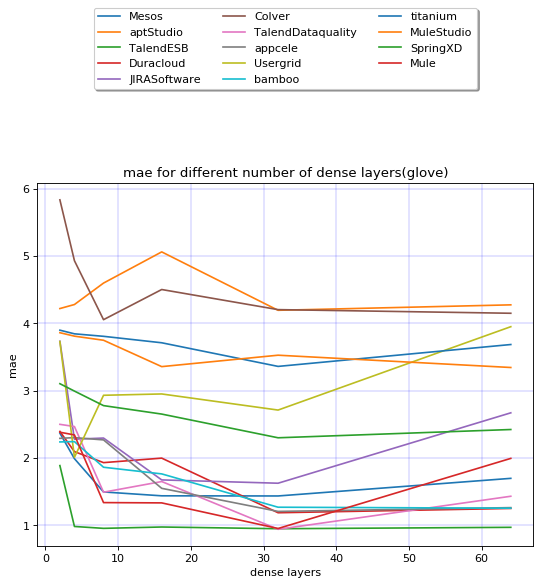

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
epochRange = [2,4,8,16,32,64]
plt.plot(epochRange,a)
plt.plot(epochRange,b)
plt.plot(epochRange,c)
plt.plot(epochRange,d)
plt.plot(epochRange,e)
plt.plot(epochRange,f)
plt.plot(epochRange,g)
plt.plot(epochRange,h)
plt.plot(epochRange,i)
plt.plot(epochRange,j)
plt.plot(epochRange,k)
plt.plot(epochRange,l)
plt.plot(epochRange,m)
plt.plot(epochRange,n)
#plt.plot(epochRange,mae_dense_8)
#plt.plot(epochRange,mae_dense_16)
plt.title('mae for different number of dense layers(glove)')
plt.ylabel('mae')
plt.xlabel('dense layers')
plt.legend(files, loc='upper center', bbox_to_anchor=(0.5,1.5),
          ncol=3, fancybox=True, shadow=True)
plt.grid(color='b', linestyle='-', linewidth=0.2)
plt.show()

**classification**

In [ ]:
%%time
%%time
import warnings
warnings.filterwarnings('ignore')
accuracy_glove=[]
count=1
## some config values 
embed_size = 300 # how big is each word vector
max_features = 1000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use
import glob
#path where the dataset files are saved
path = "../input/shravan1/*.csv"
for fname in glob.glob(path):
    print(count,'/14')
    count=count+1
    df=pd.read_csv(fname,encoding='latin-1')
 #--------preprocessing--------#   
  
    def preprocess(sentence):
        sentence=str(sentence)
        sentence = sentence.lower()
        sentence=sentence.replace('{html}',"") 
        cleanr = re.compile('<.*?>')
        cleantext = re.sub(cleanr, '', sentence)
        rem_url=re.sub(r'http\S+', '',cleantext)
        rem_num = re.sub('[0-9]+', '', rem_url)
        tokenizer = RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(rem_num)  
        filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
        return " ".join(filtered_words)

    df['mergeText']=df['title'] .map(str)+str(" ")+df['description']
    df['cleanText']=df['mergeText'].map(lambda s:preprocess(s)) 
    print(fname, 'preprocessing done')
    
    #---------train_test_split (70:30)---------#
    train_df, val_df = train_test_split(df, test_size=0.3, random_state=2018)
    

    if max(df['storypoint'])>20:
        for i in range(0,len(df['storypoint']),1):
            if df['storypoint'][i]<=10 :
                df['storypoint'][i]='low'
            elif (df['storypoint'][i]<=20 and df['storypoint'][i] >10):
                df['storypoint'][i]='medium'
            else:
                df['storypoint'][i]='high'
                
    elif (max(df['storypoint'])>10 & max(df['storypoint'])<=20):
         for i in range(0,len(df['storypoint']),1):
            if df['storypoint'][i]<=5 :
                df['storypoint'][i]='low'
            elif (df['storypoint'][i]<=12 and df['storypoint'][i] > 5):
                df['storypoint'][i]='medium'
            else:
                df['storypoint'][i]='high'
    else:
         for i in range(0,len(df['storypoint']),1):
            if df['storypoint'][i]<=3 :
                df['storypoint'][i]='low'
            elif (df['storypoint'][i]<=5 and df['storypoint'][i] > 3):
                df['storypoint'][i]='medium'
            else:
                df['storypoint'][i]='high'
    one_hot = pd.get_dummies(df['storypoint'])
    print(fname,"one_hot_encoding done ")
    # Drop column B as it is now encoded
    df = df.drop(['storypoint'],axis = 1)
    # Join the encoded df
    df = df.join(one_hot)  
    
    list_classes = ['low','medium','high']
    y = df[list_classes].values
    
    #---------train_test_split---------#
     ## Get the target values
    X = df["cleanText"].fillna("_na_").values
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.3)


    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(train_X))
    train_X = tokenizer.texts_to_sequences(train_X)
    val_X = tokenizer.texts_to_sequences(val_X)

    ## Pad the sentences 
    train_X = pad_sequences(train_X, maxlen=maxlen)
    val_X = pad_sequences(val_X, maxlen=maxlen)
    
    #Load glove embedding file
    EMBEDDING_FILE = '../input/embeddings/glove.840B.300d/glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]


    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
    
    print(fname, 'embedding done')
  
    inp = Input(shape=(maxlen,))
    x = Embedding(max_features, embed_size)(inp)
    x = Bidirectional(GRU(64, return_sequences=True))(x)
    x = GlobalMaxPool1D()(x)
    x = Dense(32, activation="relu")(x)
    x = Dropout(0.1)(x)
    x = Dense(3, activation="sigmoid")(x) 
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    batch_size = 32
    epochs = 4
    hist = model.fit(train_X,train_y, batch_size=batch_size, epochs=epochs, validation_split=0.3) 
    ## Train the model 
    print(fname, 'training done')
    y_pred = model.predict(pd.DataFrame(val_X))# predicting model on test data and store
    print(fname, 'prediction done')
    accuracy_glove.append(hist.history['val_acc'][3])

In [50]:
acc_files=pd.DataFrame(columns=('files','accuracy'),index=range(0,14))

In [51]:
acc_files['files']=pd.DataFrame(files)
acc_files['accuracy']=pd.DataFrame(accuracy_glove)

In [52]:
acc_files

,files,accuracy
0,Mesos,98.23
1,aptStudio,97.44
2,TalendESB,93.56
3,Duracloud,95.67
4,JIRASoftware,92.65
5,Colver,97.45
6,TalendDataquality,98.45
7,appcele,94.89
8,Usergrid,97.56
9,bamboo,96.34
